In [4]:
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch-geometric -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import pandas as pd
import scipy.io
import torch
from torch_geometric.loader import DataLoader
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")


device: cuda


In [6]:
if not os.path.exists('qm7.mat'):
  os.system('wget http://www.quantum-machine.org/data/qm7.mat')
data = scipy.io.loadmat('qm7.mat')
y = data['T'].reshape(-1,)
y_scaling_factor = np.max(np.absolute(y))
rand_state = 42

In [21]:
from torch_geometric.data import Data, InMemoryDataset, download_url

# Modified from original QM7b loader from PyG
class QM7(InMemoryDataset):

    url = 'http://www.quantum-machine.org/data/qm7.mat'

    def __init__(self, root, transform=None, pre_transform=None,
                 pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return 'qm7.mat'

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        download_url(self.url, self.raw_dir)

    def process(self):
        data = scipy.io.loadmat(self.raw_paths[0])
        coulomb_matrix = torch.from_numpy(data['X'])
        y = np.transpose(data['T']).reshape((7165,))
        y_scaling_factor = np.max(np.absolute(y))
        y_scaled = y/y_scaling_factor
        target = torch.from_numpy(y_scaled).to(torch.float)

        data_list = []
        for i in range(target.shape[0]):
            edge_index = coulomb_matrix[i].nonzero(as_tuple=False).t()
            edge_attr = coulomb_matrix[i, edge_index[0], edge_index[1]]
            diag = torch.diagonal(coulomb_matrix[i], 0)
            x = diag[diag.nonzero(as_tuple=False)]
            y = target[i].view(1, -1)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            data.num_nodes = edge_index.max().item() + 1
            data.num_node_features = 1
            data.num_edge_features = 1
            data_list.append(data)

        if self.pre_filter is not None:
            data_list = [d for d in data_list if self.pre_filter(d)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(d) for d in data_list]

        self.save(data_list,self.processed_paths[0])


In [8]:
dataset = QM7(root='data/qm7')

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Processing...


Dataset: QM7(7165):
Number of graphs: 7165
Number of features: 1


Done!


In [32]:
# Define GNN
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        torch.manual_seed(rand_state)
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.conv3 = GCNConv(16, 8)
        self.lin = Linear(8, 1)
    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)
        return x

# Initialize the model, loss function and optimizer
model = GNN().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss(reduction='sum')


GNN(
  (conv1): GCNConv(1, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 8)
  (lin): Linear(in_features=8, out_features=1, bias=True)
)


In [22]:
NUM_EPOCHS = 50

# Define training function
def train(model,criterion,optimizer,train_loader):
    # Set model to training mode
    model.train()

    running_loss = 0.0
    for data in train_loader:  # Iterate in batches over the training dataset.
        # Move the input data to the specified device (CPU or GPU)
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.edge_attr = data.edge_attr.to(device)
        data.batch = data.batch.to(device)
        data.y = data.y.to(device)
        data.ptr = data.ptr.to(device)
        # Reset the gradients of all the parameters to zero before backpropagation
        optimizer.zero_grad()

        # Perform a forward pass through the model to get the output predictions
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)  # Perform a single forward pass.
        # Compute the loss between the model's output and the target labels
        loss = criterion(out, data.y)
        # Perform backpropagation to compute the gradients of the loss with respect to the model parameters
        loss.backward()
        # Update the model parameters using the computed gradients
        optimizer.step()
        # Accumulate the loss value for monitoring
        running_loss += loss.item()
    # Return the average running loss over the entire dataset
    return running_loss/len(train_loader.dataset)

# Define validation function
def val(model,criterion,val_loader):
    # Set model to evaluation mode
    model.eval()
    # Monitoring average loss for one epoch
    running_loss = 0.0
    for data in val_loader:
        # Move the input data to the specified device (CPU or GPU)
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.edge_attr = data.edge_attr.to(device)
        data.batch = data.batch.to(device)
        data.y = data.y.to(device)
        data.ptr = data.ptr.to(device)
        # Perform a forward pass through the model to get the output predictions
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # Compute the loss between the model's output and the target labels
        loss = criterion(out, data.y)  # Compute the loss.
        # err += torch.mean(torch.abs(out - data.y)).item()
        running_loss += loss.item()
    # Return the average running loss over the entire dataset
    return running_loss/len(val_loader.dataset)

In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        # Initialize the EarlyStopper with a specified patience and minimum delta
        self.patience = patience  # Number of epochs with no improvement after which training will be stopped
        self.min_delta = min_delta  # Minimum change in the monitored quantity to qualify as an improvement
        self.counter = 0  # Counter to keep track of epochs with no improvement
        self.min_validation_loss = float('inf')  # Best observed validation loss initialized to infinity

    def early_stop(self, validation_loss):
        # Check if the validation loss has improved
        if validation_loss < self.min_validation_loss:
            # If validation loss has improved, update the best observed validation loss and reset the counter
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # If validation loss has not improved and exceeds the threshold (min_validation_loss + min_delta)
            # increment the counter
            self.counter += 1
            # If the counter exceeds the patience, return True to indicate early stopping
            if self.counter >= self.patience:
                return True
        # Return False to indicate no early stopping
        return False


In [33]:
def crossvalid(model=None, criterion=None, optimizer=None, dataset=None, indices=None):
    # Save the initial state of the model's weights
    model_wts = copy.deepcopy(model.state_dict())

    # Initialize list to store training and validation scores for each fold
    train_score = []
    val_score = []

    # Perform 5-fold cross-validation
    for i in range(5):
        print(f"============Fold {i+1}============")

        # Reset the model's weights to the initial state at the start of each fold
        model.load_state_dict(model_wts)

        # Initialize early stopping mechanism
        early_stopper = EarlyStopper(patience=3, min_delta=0.005)

        # Prepare training and validation indices for the current fold
        train_indices = indices[list(range(0, i)) + list(range(i+1, 5))]
        val_indices = indices[i]

        # Create training and validation datasets for the current fold
        train_set = dataset[train_indices]
        val_set = dataset[val_indices]

        # Create data loaders for training and validation datasets
        train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=50, shuffle=False)

        # Lists to track loss for each epoch
        loss_epoch_trn_list = []
        val_epoch_trn_list = []

        # Train the model for a set number of epochs
        for epoch in range(NUM_EPOCHS):
            # Perform a training step and record the training loss
            train_loss = train(model, criterion, optimizer, train_loader)
            loss_epoch_trn_list.append(train_loss)

            # Perform a validation step and record the validation loss
            val_loss = val(model, criterion, val_loader)
            val_epoch_trn_list.append(val_loss)

            print("Epoch: {}, Train Loss: {}, Test Loss: {}".format(epoch+1, train_loss, val_loss))

            # Check if early stopping criteria are met
            if early_stopper.early_stop(val_loss):
                break

        # Store the final training and validation loss for the current fold
        train_score.append(loss_epoch_trn_list)
        val_score.append(val_epoch_trn_list)

    # Return the training and validation scores for all folds
    return train_score, val_score

# Perform cross-validation and retrieve training and validation scores
train_score, val_score = crossvalid(model, criterion, optimizer, dataset=dataset, indices=data['P'])


============Fold 1============
Epoch: 1, Train Loss: 0.23714598233435258, Test Loss: 0.22337030948497827
Epoch: 2, Train Loss: 0.1934639362713214, Test Loss: 0.16718157038186202
Epoch: 3, Train Loss: 0.1247061985568907, Test Loss: 0.07864289639799726
Epoch: 4, Train Loss: 0.07488463632892414, Test Loss: 0.057435441832399334
Epoch: 5, Train Loss: 0.056538449703024886, Test Loss: 0.05491537991222267
Epoch: 6, Train Loss: 0.054611004530260465, Test Loss: 0.05686814570377028
Epoch: 7, Train Loss: 0.055380704992730886, Test Loss: 0.04893189448205558
Epoch: 8, Train Loss: 0.05309505861535908, Test Loss: 0.051084265788784416
Epoch: 9, Train Loss: 0.052488429909890465, Test Loss: 0.04914518710374
Epoch: 10, Train Loss: 0.05150431174127189, Test Loss: 0.04797137424152212
Epoch: 11, Train Loss: 0.05209440381811452, Test Loss: 0.05584575758892094
Epoch: 12, Train Loss: 0.05160752088559398, Test Loss: 0.05161063328374955
Epoch: 13, Train Loss: 0.05077306517586372, Test Loss: 0.04742997323227195
Ep

In [34]:
print(f"Average train loss: {np.mean([score[-1] for score in train_score])*y_scaling_factor}")
print(f"Average test loss: {np.mean([score[-1] for score in val_score])*y_scaling_factor}")

Average train loss: 105.9864801904661
Average test loss: 116.38527759717047


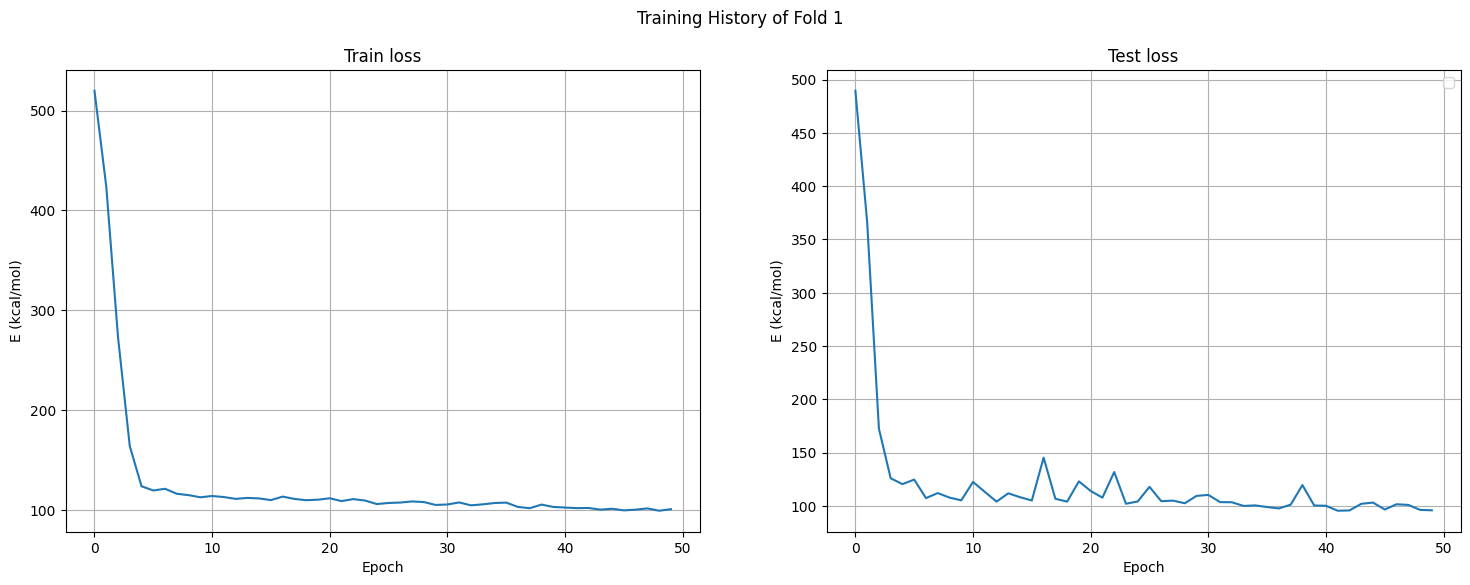

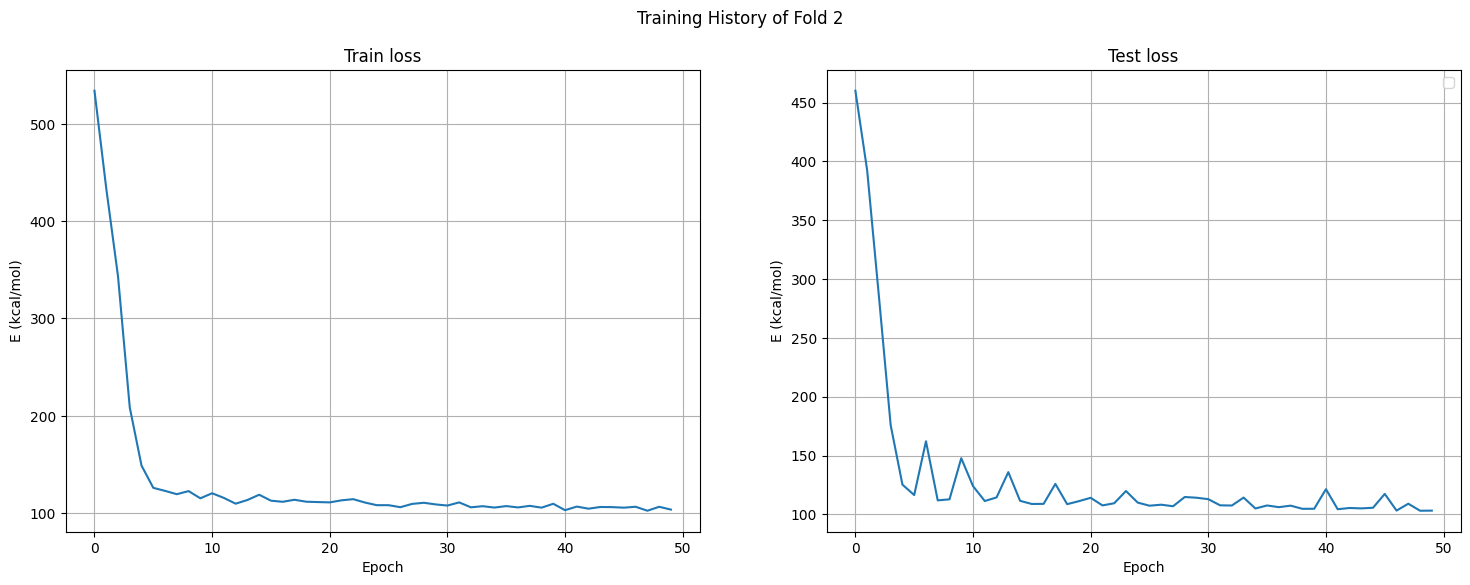

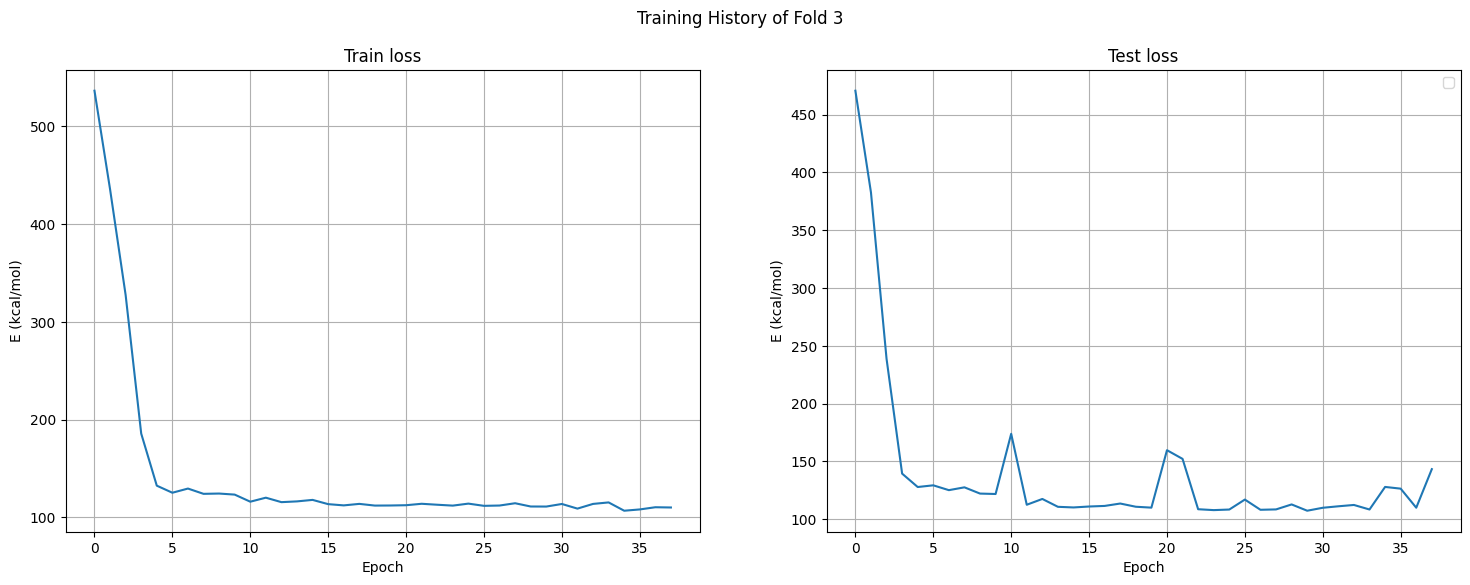

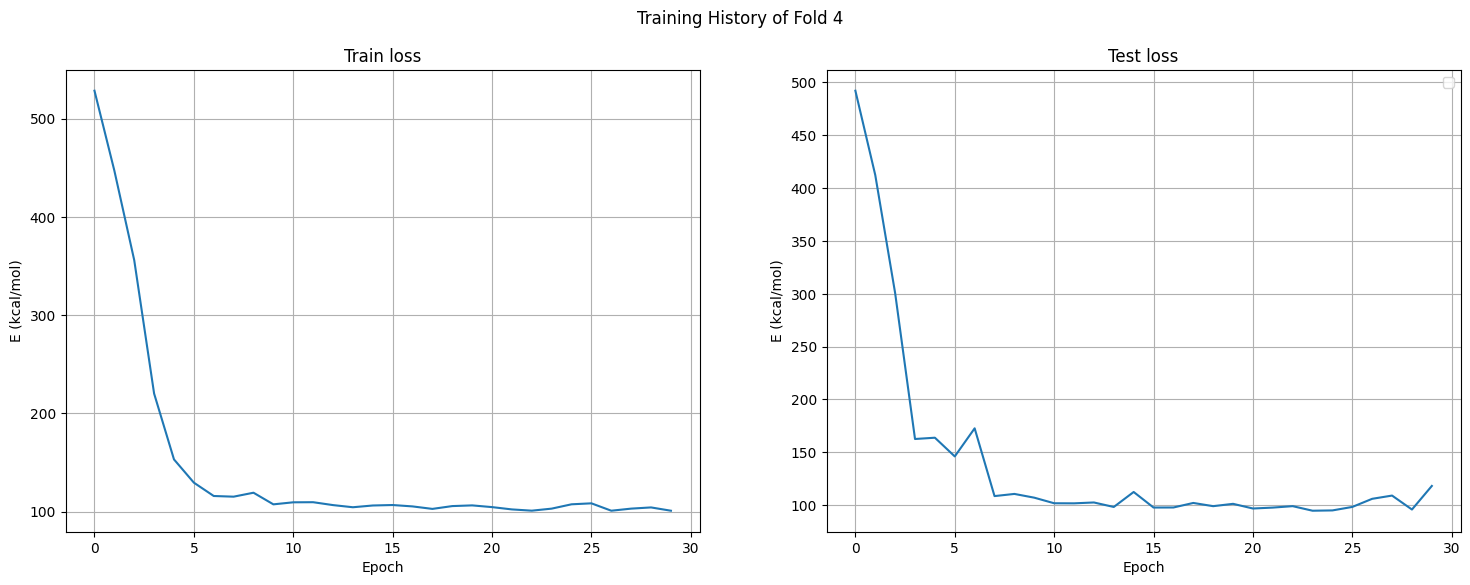

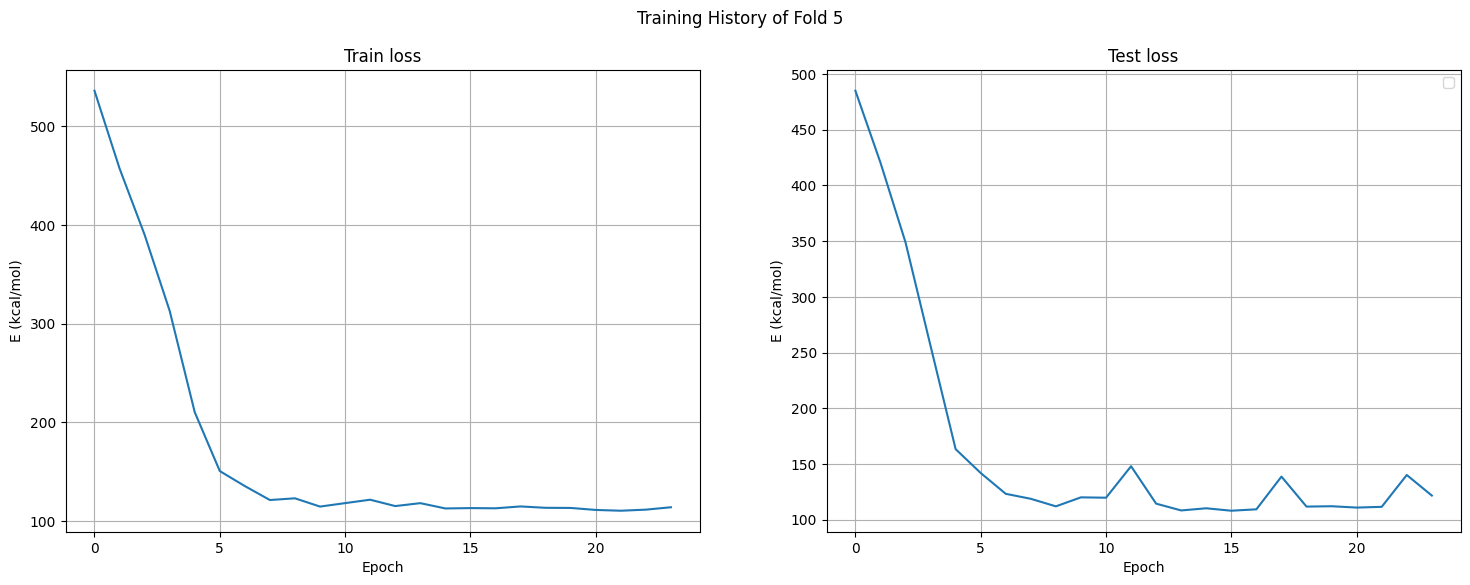

In [35]:
from matplotlib import pyplot as plt

for i in range(5):
# Plot training history
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  fig.suptitle(f'Training History of Fold {i+1}')
  ax1.plot([score*y_scaling_factor for score in train_score[i]])
  ax1.set_title("Train loss")
  ax2.plot([score*y_scaling_factor for score in val_score[i]])
  ax2.set_title("Test loss")
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('E (kcal/mol)')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('E (kcal/mol)')
  plt.legend()
  ax1.grid(True)
  ax2.grid(True)